Comprehensive breakdown of all the processes that lead to final datasets


In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/

Let's start with what the data we receive from Lundennberg lab are.

#### 🗂 TO2 Folder Summary

- **Contents**:
  - `220221_MS__TO_mousebrain_Cy3_MV_gain5.jpg`: Fluorescent image of matrixed brain sections (Cy3 channel)
  - `fluo.csv`: Matrix intensity metadata (Area, mean, max, integrated density) for different MALDI matrices

- **Used in Analysis?**: ❌ No direct use
- **Potential Info**:
  - Matrix intensity profiles
  - Sample quality indicators
  - Layout & prep metadata for cross-reference


### 🔸 Sample Block: V11L12-038_A1

#### 🧬 RNA Modality
**Path:** `/.../V11L12-038/V11L12-038_A1/output_data/V11L12-038_A1_RNA/outs`

- **Data Type**: 10x Visium (Space Ranger output)
- **Main Matrix**: `filtered_feature_bc_matrix.h5` → used to build `.X`
- **Spatial Info**:
  - `tissue_positions_list.csv`: barcode → (x, y) coordinates
  - `scalefactors_json.json`: pixel → micron scaling
  - `tissue_hires_image.png`: for visualization
- **QC Metrics**:
  - `metrics_summary.csv` and `web_summary.html`
- **Tissue Annotation**:
  - `region.csv`, `lesion.csv` → possibly used for defining ROI or labels

#### ✅ Used in:
- `lipids_plate1_only`
- `lipids_concat` (combined with B1, C1, D1)

#### 📎 Notes:
- This RNA sample is fully spatial and has all required Visium metadata.
- `.X` will represent gene expression (spots × genes), and `.obsm` may include embeddings like SVD or scVI later on.


In [2]:
og_V11L12038 = sc.read_visium("/lustre/groups/ml01/workspace/eirini.giannakoulia/KTH/sma/sma/V11L12-038/V11L12-038_A1/output_data/V11L12-038_A1_RNA/outs")

/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
og_V11L12038

AnnData object with n_obs × n_vars = 2856 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [8]:
og_V11L12038.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 5937614 stored elements and shape (2856, 32285)>

In [9]:
import numpy as np

# Convert a small slice to dense format to inspect values
X_dense_preview = og_V11L12038.X[:5, :5].toarray() if hasattr(og_V11L12038.X, "toarray") else og_V11L12038.X[:5, :5]

print(X_dense_preview)


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [5]:
og_V11L12038.obsm['spatial']

array([[34368, 30106],
       [ 7356, 26604],
       [ 8520, 28623],
       ...,
       [27096, 20515],
       [12584, 27608],
       [19530,  8397]])

## 🧬 RNA Preprocessing Summary – V11L12-038_A1

The RNA data for this sample was preprocessed using a custom function `rna_pp()` designed by Maiia (found in PP_MOSCOT_alignment). The goal of this pipeline is to ensure high-quality data by removing low-quality spots and genes, followed by normalization and dimensionality reduction. Below is a detailed breakdown of each preprocessing step:

---

### 🧹 1. **Filtering & Quality Control**

**Spot filtering:**
- Spots with fewer than **1,000 total counts** were removed (likely low coverage or empty regions).
- Spots with more than **35,000 total counts** were removed (likely artifacts or doublets).
- Spots with **>20% mitochondrial content** (`MT-` genes) were removed to reduce inclusion of stressed/damaged tissue.
- Spots with **<1,000 detected genes** were also excluded.

**Gene filtering:**
- Genes were kept only if they were expressed in **≥10 spots**, to focus on biologically informative features.

Resulting data shape after filtering:  
➡️ `2815 spots × 14479 genes`

---

### 🧪 2. **Normalization & Transformation**

After filtering, the following normalization steps were applied to prepare the data for dimensionality reduction:

1. **Total count normalization:**  
   - Each spot’s total count was scaled to **10,000** (CPM-like normalization).
   - This removes library size effects between spots.

2. **Log1p transformation:**  
   - A natural log + 1 (`log(1 + x)`) was applied to normalized values.
   - This reduces the effect of large outlier values and makes distributions more Gaussian-like, which is beneficial for PCA.

Result:  
- `.X` now contains **log-transformed, total-count-normalized expression values**.

---

### 📦 Additional Computed Features

- **Highly variable genes:** Top 2,000 HVGs identified using the Seurat method.
- **Dimensionality reduction:** 50-component PCA performed on HVGs.
- **Graph and clustering:**
  - 100-nearest-neighbor graph built in PCA space.
  - UMAP embedding and Leiden clustering applied.
- **Spatial graph:** Moran’s I autocorrelation was computed to assess spatial gene expression structure.
- **Metadata annotations:**
  - `.obsm['raw_counts']` stores raw counts before normalization.
  - `.obs['technology']` and `.var['technology']` both set to `"RNA"`.

---


## 🧬 RNA Preprocessing Summary – V11L12-038_A1

The RNA data for this sample was preprocessed using a custom function `rna_pp()` designed by the supervisor. The goal of this pipeline is to ensure high-quality data by removing low-quality spots and genes, followed by normalization and dimensionality reduction. Below is a detailed breakdown of each preprocessing step:

---

### 🧹 1. **Filtering & Quality Control**

**Spot filtering:**
- Spots with fewer than **1,000 total counts** were removed (likely low coverage or empty regions).
- Spots with more than **35,000 total counts** were removed (likely artifacts or doublets).
- Spots with **>20% mitochondrial content** (`MT-` genes) were removed to reduce inclusion of stressed/damaged tissue.
- Spots with **<1,000 detected genes** were also excluded.

**Gene filtering:**
- Genes were kept only if they were expressed in **≥10 spots**, to focus on biologically informative features.

Resulting data shape after filtering:  
➡️ `2815 spots × 14479 genes`

---

### 🧪 2. **Normalization & Transformation**

After filtering, the following normalization steps were applied to prepare the data for dimensionality reduction:

1. **Total count normalization:**  
   - Each spot’s total count was scaled to **10,000** (CPM-like normalization).
   - This removes library size effects between spots.

2. **Log1p transformation:**  
   - A natural log + 1 (`log(1 + x)`) was applied to normalized values.
   - This reduces the effect of large outlier values and makes distributions more Gaussian-like, which is beneficial for PCA.

Result:  
- `.X` now contains **log-transformed, total-count-normalized expression values**.

---

### 📦 Additional Computed Features

- **Highly variable genes:** Top 2,000 HVGs identified using the Seurat method.
- **Dimensionality reduction:** 50-component PCA performed on HVGs.
- **Graph and clustering:**
  - 100-nearest-neighbor graph built in PCA space.
  - UMAP embedding and Leiden clustering applied.
- **Spatial graph:** Moran’s I autocorrelation was computed to assess spatial gene expression structure.
- **Metadata annotations:**
  - `.obsm['raw_counts']` stores raw counts before normalization.
  - `.obs['technology']` and `.var['technology']` both set to `"RNA"`.

---
So we arrive to our final adata_rna h5ad object, filtered and normalized

### 🧩 Matching MSI and RNA Spots after MOSCOT Alignment

Although MOSCOT aligns MSI and RNA datasets in a shared coordinate space (`obsm['spatial_warp']`), it does not enforce a strict 1-to-1 matching between observations.

To enable downstream tasks like prediction or correlation between RNA and MSI, we use spatial nearest-neighbor matching:

1. A spatial KD-tree is built on RNA's aligned coordinates.
2. For each MSI spot, we find the closest RNA spot in space.
3. The result is saved in `matching_df`, a DataFrame mapping MSI rows to RNA rows.

This allows us to reorder and filter the original AnnData objects to produce matched datasets with the **same number and ordering of observations**.

These matched datasets are later used for modeling tasks where each MSI row corresponds to a specific RNA observation.


In [11]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb
import anndata as ad
import scanpy as sc
# import moscot as mt
# from moscot.problems.space import AlignmentProblem
import squidpy as sq

/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [13]:
path_rna = '/lustre/groups/ml01/workspace/eirini.giannakoulia/KTH/sma/sma/V11L12-038/V11L12-038_A1/output_data/V11L12-038_A1_RNA/outs'

In [14]:
adata_rna = sc.read_visium(path_rna)

/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


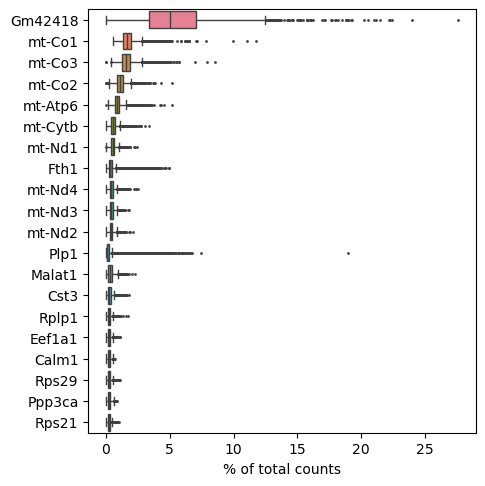

Number of cells after min count filter: 2817
Number of cells after max count filter: 2815
Number of cells after MT filter: 2815
Number of genes after cell filter: 14479


/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [15]:
adata_rna = rna_pp(adata_rna)

In [16]:
adata_rna.obsm['raw_counts'] = adata_rna.X.copy()
# Normalization and log-transformation
sc.pp.normalize_total(adata_rna, inplace=True)
sc.pp.log1p(adata_rna)
# Identify highly variable genes
sc.pp.highly_variable_genes(adata_rna, flavor='seurat', n_top_genes=2000, inplace=True)
# Dimensionality reduction using PCA
sc.pp.pca(adata_rna, n_comps=50, use_highly_variable=True, svd_solver='arpack')
# Construct a neighborhood graph
sc.pp.neighbors(adata_rna, n_neighbors=100)
# Compute UMAP embedding
sc.tl.umap(adata_rna)
# Leiden clustering
sc.tl.leiden(adata_rna, key_added='clusters')
# Add technology lable
adata_rna.obs['technology'] = 'RNA'
adata_rna.var['technology'] = 'RNA'
# Add spatially variable genes
sq.gr.spatial_neighbors(adata_rna)
sq.gr.spatial_autocorr(adata_rna, mode='moran')

/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/icb/yufan.xia/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: Please install the igraph package: `conda install -c conda-forge python-igraph` or `pip3 install igraph`.

In [ ]:
adata_rna

In [ ]:
#Ploting of the RNA data
sc.pl.umap(adata_rna, color='clusters', palette=sc.pl.palettes.default_20)
sc.pl.spatial(adata_rna, img_key = "hires", color="clusters", size=1.5)

In [ ]:
adata_rna